https://arxiv.org/abs/1406.0818 
## Step 1: Set up <tt>python</tt> environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from scipy import constants
from math import floor, ceil

# Define constants
year = 365.25 # days in a year
secday = 24. * 3600. # seconds in a day
mearth = 5.9723e24 # Earth's mass in kg
mjup = 1.899e27 # kg
msun = 1.989e30 # Sun's mass in kg
au = 1.496e11 # 1 AU in meters
deg2rad = np.pi / 180.

## Step 2: Implement the Murison et al. (2006) method of solving Kepler's equation

In [2]:
# To solve Kepler's equation, make a good starting guess for eccentric anomaly
def KeplerStart3(e, M):
    # Inputs: eccentricity, mean anomaly in RADIANS
    t34 = e**2
    t35 = e*t34
    t33 = np.cos(M)
    return M + (-0.5*t35 + e + (t34 + 1.5*t33*t35)*t33) * np.sin(M)

# 3rd-order method for improving the guess for eccentric anomaly
def eps3(e, M, x):
    # Inputs: eccentricity, mean anomaly in RADIANS, estimate for eccentric anomaly in RADIANS
    t1 = np.cos(x)
    t2 = -1 + e*t1
    t3 = np.sin(x)
    t4 = e*t3
    t5 = -x + t4 + M
    t6 = t5/(0.5*t5*t4/t2 + t2)
    return t5 / ((0.5*t3 - (1./6.)*t1*t6)*e*t6 + t2);

# Solve Kepler's equation (suggested tolerance is 1e-14; Ford (2009) suggests 1e-6 is 
# good enough)
def KeplerSolve(e, M, tol):
    # Inputs: eccentricity, mean anomaly in RADIANS, tolerance
    Mnorm = M % (2*np.pi)
    E0 = KeplerStart3(e, Mnorm)
    dE = tol + 1
    count = 0
    while (dE > tol):
        EE = E0 - eps3(e, Mnorm, E0)
        dE = np.abs(EE - E0)
        E0 = EE
        count += 1
        if (count == 100):
            print("Astounding! KeplerSolve failed to converge!")
            break
    return EE

## Step 3: Test a known planet: <a href="http://exoplanet.eu/catalog/hd_23596_b/">HD 23596</a>

Mean anomaly at first observation (deg): -179.3263974441364 180.6736025558636
Semimajor axis 2.8627892180488193
chi2 =  1.2538249900724072


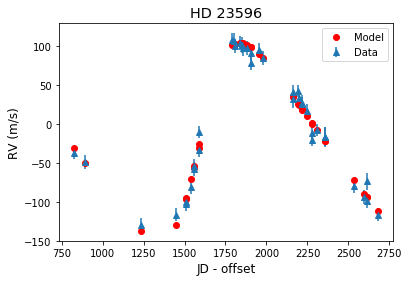

In [24]:
# HD 23596
e = 0.292
omega = 274.1 * deg2rad # radians
tp = 2451604.0 # JD -- time of periastron passage (exoplanet.eu gives tp instead of M0)
msini = 8.1 * mjup # kg
mstar = 1.27 * msun # kg
per = 1565.0 # days
jd, rv, rverr = np.loadtxt("../education/Console/datafiles/HD23596_1.vels", unpack=True)
# Mean anomalies
ma = (jd-tp)/per * 2.*np.pi
# Is the mean anomaly at t=0 consistent with what Systemic requires? M0 = 180.61 deg
print("Mean anomaly at first observation (deg):", ma[0]*180./np.pi, 360.+ma[0]*180./np.pi)
# Eccentric anomalies
ea = np.zeros_like(ma)
for i in range(len(ma)):
    ea[i] = KeplerSolve(e, ma[i], 1.0e-10)
# True anomalies
ftrue = 2.*np.arctan(np.sqrt((1.+e)/(1.-e))*np.tan(ea/2.))
# Semimajor axis
semim = np.cbrt(constants.G*(mstar+msini)/(4.*np.pi**2.)*(per*secday)**2.)
print("Semimajor axis", semim/au)
# Radial velocities
rvc = np.sqrt(constants.G/((mstar+msini)*semim*(1.-e**2.)))*msini*(np.cos(omega+ftrue) + e*np.cos(omega))
offset = -23.587 # m/s -- not listed at exoplanet.eu, measured with Systemic
jdoffset = 2450000
plt.errorbar(jd-jdoffset, rv, yerr=rverr, fmt="^", label="Data")
plt.plot(jd-jdoffset, rvc+offset, "ro", label="Model")
plt.xlabel("JD - offset", fontsize="large")
plt.ylabel("RV (m/s)", fontsize="large")
plt.title("HD 23596", fontsize="x-large")
plt.legend(loc="best")
print("chi2 = ", np.sum((rv-(rvc+offset))**2. / rverr**2. / (len(ma)-1-6)))

### Check the phase folding

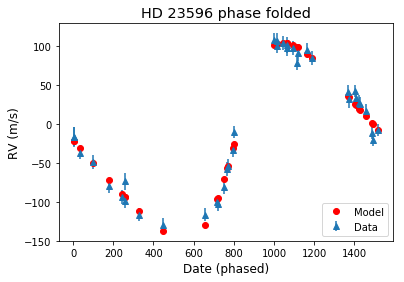

In [4]:
def phaseFold(t, v, verr, period):
    # Inputs: time of observations, velocities, errors (units don't matter here as long
    # as time and period have same units)
    pfrac = t % period
    sortsubs = np.argsort(pfrac)
    phasesort = pfrac[sortsubs]
    vsort = v[sortsubs]
    verrsort = verr[sortsubs]
    return phasesort, vsort, verrsort

jdfold, rvfold, rverrfold = phaseFold(jd, rv, rverr, per)
_, rvcfold, _ = phaseFold(jd, rvc, rverr, per)
plt.errorbar(jdfold, rvfold, yerr=rverrfold, fmt="^", label="Data")
plt.plot(jdfold, rvcfold+offset, "ro", label="Model")
plt.xlabel("Date (phased)", fontsize="large")
plt.ylabel("RV (m/s)", fontsize="large")
plt.title("HD 23596 phase folded", fontsize="x-large")
plt.legend(loc="lower right")

In [5]:
# Double-checking the mean anomaly calculation
ma0 = ma[0]
jd0 = jd[0]
macheck = 2.*np.pi * (jd-jd0) / per + ma0
for i in range(len(ma)):
    print(ma[i], macheck[i])

-3.1298360711401245 -3.1298360711401245
-2.865312765263483 -2.865312765263483
-1.4723157278455468 -1.4723157278455468
-0.6356580138235955 -0.6356580138235954
-0.3873356904841564 -0.3873356904841563
-0.37925788291949136 -0.37925788291949125
-0.25136515154700495 -0.251365151547005
-0.18699522288932063 -0.18699522288932036
-0.1749716552485203 -0.1749716552485201
-0.07489235701005531 -0.07489235701005548
-0.05487529291807098 -0.05487529291807114
0.745241984840551 0.7452419848405509
0.8056083400867678 0.8056083400867675
0.8137266972802704 0.8137266972802704
0.9298921543506269 0.9298921543506267
0.9979705675253998 0.9979705675254
1.014014570799616 1.0140145707996155
1.122124301787098 1.1221243017870983
1.2144782932098022 1.2144782932098024
1.2224846370692533 1.2224846370692535
1.41075295776148 1.41075295776148
1.5108455048908889 1.5108455048908893
2.230865218128426 2.2308652181284265
2.242844221324838 2.242844221324838
2.3673291778152645 2.367329177815265
2.3833021188669434 2.383302118866943

<p><strong>KeplerSolve and phaseFold both work.</strong></p>

# Step 4: Kapteyn's star

<p>I used <a href="https://automeris.io/WebPlotDigitizer/">WebPlotDigitizer</a> to read in both the data points and the model RV curve from the bottom panel of Anglada-Escude' Figure 2, bottom panel ("planet c"). Two reasons: (1) I wanted to see if I could reproduce their planet model, and (2) if all else fails, I can get the $\chi^2$ per degree of freedom directly from their own plot.</p>

0.02201479726171669


Text(0.5,1,'Anglada-Escude fig. 2, planet c')

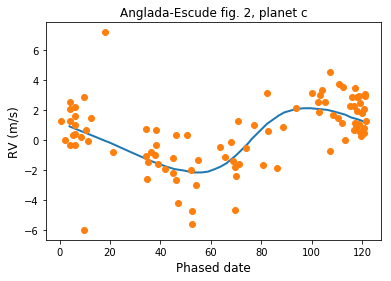

In [21]:
mKap = 0.281 * msun # kg
# Planet 1
eb = 0.21
omegab = 80.4 * deg2rad # radians
ma0b = 269.6 * deg2rad # radians
msinib = 4.8 * mearth # kg
perb = 48.616 # days
# Planet 2
ec = 0.23
omegac = 3.9 * deg2rad # radians
ma0c = 357.6 * deg2rad # radians
msinic = 7.0 * mearth # kg
print(msinic/mjup)
perc = 121.54 # days
# Long-term trend
gammaDot = -0.181 # (m/s) / yr
# Reference epoch
jdref = 2452985.74111
# Augmented error bars
sigHarps = 0.65
sigHires = 1.17
sigPfs = 0.32
# Read in measured RVs phased to planet c (this is a subset: I could not extract all the
# points from the bottom panel of Anglada-Escude' figure 2 because of plot symbol overlap)
jdPhasec, rvPhasec = np.loadtxt("Kapteyn_planet_c_phasedRV.txt", comments="#", unpack=True)
# Read in model RV curve for planet c, also extracted from figure 2 of Anglada-Escude'
jdmodc, rvmodc = np.loadtxt("Kapteyn_planet_c_model.txt", comments="#", unpack=True)
# Sanity check: plot the phased data and model RV curve from Anglada-Escude' et al.
# make sure we're reproducing their fig. 2, bottom panel
plt.plot(jdmodc, rvmodc, lw=2)
plt.plot(jdPhasec, rvPhasec, "o")
plt.xlabel("Phased date", fontsize="large")
plt.ylabel("RV (m/s)", fontsize="large")
plt.title("Anglada-Escude fig. 2, planet c")

### Can I reproduce the model RV curve for "planet c"?

Semimajor axis 0.3145517764238528


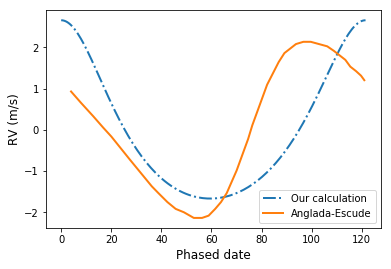

In [19]:
# Test using synthetic array of phased dates.
xdate = np.linspace(0., perc, 201, endpoint=True)
# Mean anomalies
testmac = 2.*np.pi * (xdate/perc) + ma0c
# Eccentric anomalies
testeac = np.zeros_like(testmac)
for i in range(len(testmac)):
    testeac[i] = KeplerSolve(ec, testmac[i], 1.0e-14)
# True anomalies
testftruec = 2.*np.arctan(np.sqrt((1.+ec)/(1.-ec))*np.tan(testeac/2.))
# Semimajor axis
semimc = np.cbrt(constants.G*(mKap+msinic)/(4.*np.pi**2.)*(perc*secday)**2.)
print("Semimajor axis", semimc/au)
# Radial velocities
testrvmodc_calc = np.sqrt(constants.G/((mKap+msinic)*semimc*(1.-ec**2.)))*msinic*(np.cos(omegac+testftruec) + ec*np.cos(omegac))
plt.plot(xdate, testrvmodc_calc, '-.', lw=2, label="Our calculation")
plt.plot(jdmodc, rvmodc, lw=2, label="Anglada-Escude")
plt.xlabel("Phased date", fontsize="large")
plt.ylabel("RV (m/s)", fontsize="large")
plt.legend(loc="best")

#### Not with the standard definitions of $M_0$ and $\omega$...

### Play around with non-standard reference frames for the angles and/or phase shifts until I replicate the Anglada-Escude' model

Semimajor axis 0.3145517764238528


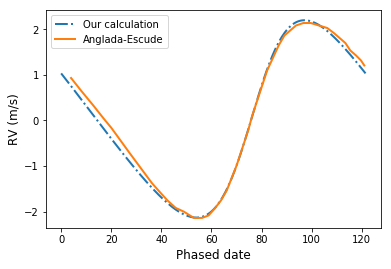

In [12]:
# Measuring omega from a plane that's perpendicular to the standard sky plane?
omegac_adj = omegac + 1.5*np.pi
# Mean anomalies
testmac_adj = testmac + 0.5*np.pi # This gets pretty close
# This is pretty strange...I have to phase-shift by 135 degrees to match the published model.
# Also, the curve is not a perfect match. Given that the calculation can be done analytically,
# it should be. However, mean anomaly is arbitrary--just depends on where you like to set the
# t=0 for the phase fold.
testmac_adj += np.pi/4. 
# Eccentric anomalies
testeac = np.zeros_like(testmac_adj)
for i in range(len(testmac_adj)):
    testeac[i] = KeplerSolve(ec, testmac_adj[i], 1.0e-14)
# True anomalies
testftruec = 2.*np.arctan(np.sqrt((1.+ec)/(1.-ec))*np.tan(testeac/2.))
# Semimajor axis
semimc = np.cbrt(constants.G*(mKap+msinic)/(4.*np.pi**2.)*(perc*secday)**2.)
print("Semimajor axis", semimc/au)
# Radial velocities
testrvmodc_calc = np.sqrt(constants.G/((mKap+msinic)*semimc*(1.-ec**2.)))*msinic*(np.cos(omegac_adj+testftruec) + ec*np.cos(omegac_adj))
plt.plot(xdate, testrvmodc_calc, '-.', lw=2, label="Our calculation")
plt.plot(jdmodc, rvmodc, lw=2, label="Anglada-Escude")
plt.xlabel("Phased date", fontsize="large")
plt.ylabel("RV (m/s)", fontsize="large")
plt.legend(loc="best")

#### Experiment with matching Systemic mean anomaly to Anglada-Escude': I think Systemic defaults to date of first observation as reference epoch, but I'm not totally sure

In [44]:
jdfirst = 2451170.92507
mfirst = 360.*(jdfirst-jdref) / perc + ma0c
ma0S = mfirst % 360
print("Mean anomaly at first observation (deg):", ma0S)
print("360 - M(t=0):", 360 - ma0S)
print("Both + 180 to account for 50 percent phase fold:", ma0S+180, 360-(ma0S+180))

Mean anomaly at first observation (deg): 30.778286051003306
360 - M(t=0): 329.2217139489967
Both + 180 to account for 50 percent phase fold: 210.7782860510033 149.2217139489967


### Go back to the standard definition of $\omega$

#### Read in results from Systemic: P, $\omega$, e, and $M \sin i$ are the same as planet c in Anglada-Escude'. I'm not sure where $t=0$ is in Systemic's phase-folded plot, so I'm just choosing the mean anomaly that best matches the <it>standard</it> definition of $\omega$.

Semimajor axis 0.3145517764238528


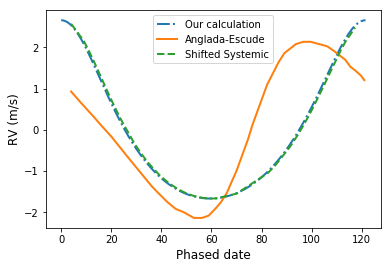

In [48]:
jdSys, errsys, fitSys = np.loadtxt("../education/Console/fits/Kapteyn_export.txt", usecols=[0,2,3], \
                          unpack=True)
# I found the 42 days by trial and error
jdSysfold, rvSysfold, _ = phaseFold(jdSys-42, fitSys, errsys, perc)
# Go back to original longitude of periastron and mean anomaly
testeac = np.zeros_like(testmac)
for i in range(len(testmac)):
    testeac[i] = KeplerSolve(ec, testmac[i], 1.0e-14)
# True anomalies
testftruec = 2.*np.arctan(np.sqrt((1.+ec)/(1.-ec))*np.tan(testeac/2.))
# Semimajor axis
semimc = np.cbrt(constants.G*(mKap+msinic)/(4.*np.pi**2.)*(perc*secday)**2.)
print("Semimajor axis", semimc/au)
# Radial velocities
testrvmodc_calc = np.sqrt(constants.G/((mKap+msinic)*semimc*(1.-ec**2.)))*msinic*(np.cos(omegac+testftruec) + ec*np.cos(omegac))
plt.plot(xdate, testrvmodc_calc, '-.', lw=2, label="Our calculation")
plt.plot(jdmodc, rvmodc, lw=2, label="Anglada-Escude")
plt.plot(jdSysfold, rvSysfold, '--', lw=2, label="Shifted Systemic")
plt.xlabel("Phased date", fontsize="large")
plt.ylabel("RV (m/s)", fontsize="large")
plt.legend(loc="best")

In [50]:
# What's the mean anomaly for a phase-shift of -42 days?
maSys = 360. * (perc-42.) / perc
print("Systemic mean anomaly:", maSys)

Systemic mean anomaly: 235.5965114365641


## Conclusions: 

### Using the standard definition of $\omega$ (longitude of periastron), it's not possible to replicate the Anglada-Escude' model for planet c. KeplerSolve and Systemic calculations agree on the shape of the RV curve for $\omega = 3.9^{\circ}$.

### You can come close to matching the Anglada-Escude' model for planet c by adding 3$\pi$ / 2 to $\omega$. Are they measuring from a different reference line, or is there simply an error in their Table 2?

### We don't know which JD corresponds to $t = 0$ on their phased date plot, so it's going to be extremely difficult to compute a reduced $\chi^2$.